# Convolutional Neural Network Architectures 6 - Residual Networks

# Convolutional Neural Networks 9 -  ResNet

In the previous notebooks, we saw that we can extremely increase performance on generalization error by increasing the depth of our model. However, increasing depth comes with an important obstacle: the vanishing gradient problem. The problem is that the gradients of the initial layers get closer and closer to zero and layers start outputting only zero. Think of it as if the is a proper signal at the beginning of our neural network, for instance, a sin signal as demonstrated below.

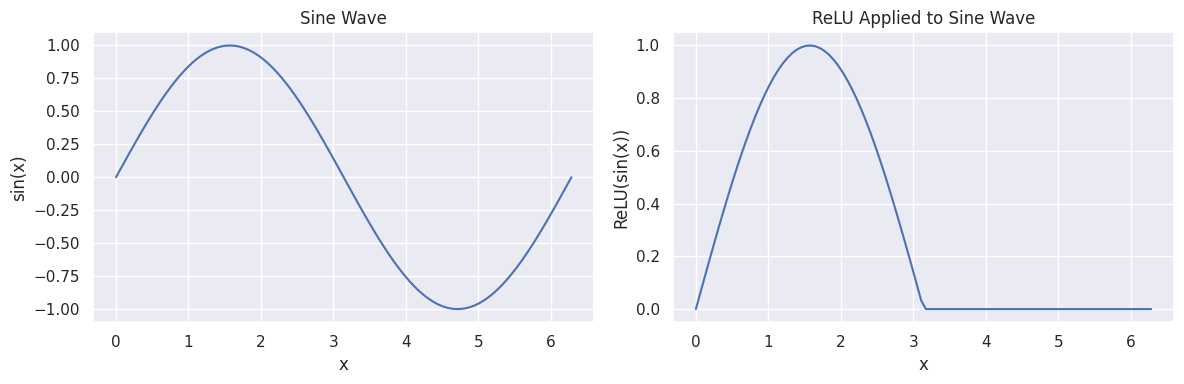

In [ ]:
from dataprocessing import plot_vawes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plot_vawes()

As can be seen in the plot above, ReLU outputs zero whenever we have a negative input. This might cause the dead ReLU problem where ReLU saturates at 0, meaning it maps all the inputs above or below 0 to the same output value, resulting in a "dead" neuron that does not contribute to the learning process. Moreover, the vanishing gradient problem may occur when the gradients during backpropagation become very small, approaching or effectively reaching zero. In such cases, the ReLU activation function may receive small or zero gradients, causing the neuron to become "dead" and not update its weights significantly during training. Moreover, when the neural network depth is so big, this saturation problem will be a bigger obstacle as it is hard to convey the signal from the beginning of the network to the end where gradient backpropagation will occur. On the other hand, another problem that is similar to the vanishing gradient problem occurs when accuracy gets saturated. This happens because even if the signal makes it to the end, because of the degradation that occurred in the signal through the layers, the signal does not convey important information about the input.

The authors of the ResNet paper asked the following question: "Is learning better networks as easy as stacking more layers?" this is actually a similar question that authors of previous papers such as VGG and Inception Network asked.

* During training, we can get negative gradients many time, one common situation where gradients can become negative is when the network is far from convergence. As the network explores different regions of the parameter space, the gradients can change sign multiple times, including becoming negative. This behavior is a consequence of the loss surface having steep valleys and peaks, causing the gradients to fluctuate in direction. - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

However, the authors of the ResNet paper came up with a better idea to solve the saturation and degradation problems where they used skip connections instead of using auxiliary output layers such as we have seen in Inception Network. To understand skip connections, we must first understand the idea of residual learning as skip connections are just a mere application of residual learning. Let's get started with that.

## Residual Learning
The linear designs we previously talked about, while effective to a certain extent, were not effective enough to train deeper neural networks. Residual learning introduces a distinct paradigm by incorporating residual connections into the network architecture, allowing the network to learn residual functions that capture the difference or residual information between the input and output of a layer. This concept has shown promise in addressing the degradation issue that we talked about above and enabling the successful training of deeper networks by improving convergence and gradient flow.

<img src="imgs/res1.svg"></img>
<a href="https://d2l.ai/chapter_convolutional-modern/resnet.html"> Source </a>

The main idea behind this block is to learn the residual mapping or the residual function that captures the difference between the input and the desired output. In a traditional deep neural network, each layer learns a function that transforms the input image into a more abstract representation. The final layer then combines these abstract representations to output a probability that the image is, for example, a cat or a dog. More formally, when training a neural network, the goal is to make a function $h(x)$ that models the underlying data. If we add the input x to the output of the layer as shown in the above figure, we force the model not to learn the function $h(x)$ that models the data but $$f(x)=h(x)-x$$. Then a residual function is the difference between the input and output of a layer. The final layer then combines the residuals from all of the layers to output a probability that the image is a cat or a dog. Residual learning makes it easier to train deep neural networks because it allows the network to focus on learning the most important features of the input data. The residuals can then be used to correct any errors that the network makes. You may also perceive the residual mapping as the measure of error that can be incorporated into the input to ultimately reach the desired outcome, specifically, to approximate the final function.

* Instead of hoping each few stacked layers directly fit a desired underlying mapping, we explicitly let these layers  fit a residual mapping. Formally, denoting the desired underlying mapping as H(x), we let the stacked nonlinear layers fit another mapping of F(x) := H(x)-x. The original mapping is recast into F(x)+x. We hypothesize that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers. The formulation of F(x)+x can be realized by feedforward neural networks with “shortcut connections”. - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

These shortcut connections help the network to model identity function since the network outputs a copy of its inputs and this makes the learning process easier.

* Let us consider H(x) as an underlying mapping to be fit by a few stacked layers (not necessarily the entire net), with x denoting the inputs to the first of these layers. If one hypothesizes that multiple nonlinear layers can asymptotically approximate complicated functions, then it is equivalent to hypothesize that they can asymptotically approximate the residual functions, i.e., H(x)-x (assuming that the input and output are of the same dimensions). So rather than expect stacked layers to approximate H(x), we explicitly let these layers approximate a residual function F(x) := H(x) - x. The original function thus becomes F(x)+x. Although both forms should be able to asymptotically approximate the desired functions (as hypothesized), the ease of learning might be different. - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

The key intuition behind residual learning is that if the identity mapping (i.e., the desired underlying mapping) is optimal, it should be relatively easy for the network to learn the residual mapping to refine the identity mapping. By explicitly modeling the difference between the input and output of a residual block, the network can focus on learning the residual features, which tend to be smaller in magnitude and therefore easier to optimize. But why this is the case?


* This reformulation is motivated by the counterintuitive phenomena about the degradation problem. As we discussed in the introduction, if the added layers can be constructed as identity mappings, a deeper model should have training error no greater than its shallower counterpart. The degradation problem suggests that the solvers might have difficulties in approximating identity mappings by multiple nonlinear layers. With the residual learning reformulation, if identity mappings are optimal, the solvers may simply drive the weights of the multiple nonlinear layers toward zero to approach identity mappings. - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

The main purpose of the residual connection is to learn the residual mapping, which represents the difference between the input and output of a block. If the ideal mapping is close to an identity mapping (where the input is nearly equal to the output), the network can learn to adjust the weights to approximate the identity mapping. This makes it easier for the network to learn the residual features rather than learning to reconstruct the input from scratch. The residual connection provides a shortcut for the gradient to directly propagate from the output to the input, allowing the network to focus on learning the residual mapping. More broadly, the network can potentially adopt one of two ideal strategies:

1. Identity Mapping: If the ideal mapping for a given input is very close to the identity mapping, the network has the capability to assign small weights to the layers within the residual block, effectively driving F(x) towards zero. In this case, the network would predominantly rely on the residual connection to preserve the input information, resulting in h(x) ≈ x.

2. Residual Adjustment: On the other hand, if the ideal mapping requires non-trivial adjustments or refinements to the input, the network can utilize the residual term to overcome the information loss during the training process. In this scenario, the network would learn the appropriate weights for F(x) to capture and represent the desired transformations, while the residual connection allows for the preservation of information and assists in adjusting the input.

* In real cases, it is unlikely that identity mappings are optimal, but our reformulation may help to precondition the problem. If the optimal function is closer to an identity mapping than to a zero mapping, it should be easier for the solver to find the perturbations with reference to an identity mapping, than to learn the function as a new one. We show by experiments that the learned residual functions in general have small responses, suggesting that identity mappings provide reasonable preconditioning. - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)


The choice between these two strategies is learned by the network during the training process, based on the complexity of the mapping and the specific characteristics of the dataset. The network optimizes the weights to minimize the loss function, and through this optimization process, it determines the most effective approach for achieving the desired classification or regression outcomes. Ultimately, residual learning provides the flexibility for the network to determine whether it needs to modify the input or preserve the input, allowing for adaptive learning and improved representation of complex relationships in the data. The residual connection allows the network to effectively skip unnecessary transformations and retain the input information, bypassing the residual block. By having the flexibility to learn the optimal weights, the network can adapt and choose the most suitable strategy for a given input. It's important to note that while it is possible for the network to learn identity mapping, it is not a guarantee. The network has the freedom to learn any mapping that optimizes the loss function, and this can include non-zero transformations in the residual block when necessary

Here one intuition is that we actually let the model find the function $f^*$ that captures the underlying structure of our data best in the function space (you can find more about that in the additional sources). Another intuition is that, In ResNets, during the training phase, there are two options for updating the network's weights: either by training the layers within the residual blocks or by skipping the training for those layers using skip connections. This means that different parts of the network will be trained at different rates based on the flow of error during the backward propagation step. The skip connections allow information to bypass certain layers and directly propagate to subsequent layers. By doing so, the network has the flexibility to choose whether to update the skipped layers or rely on the information passed through the skip connections. Consequently, the layers within the residual blocks can be updated more slowly or even remain unchanged during training. This dynamic training process, where different parts of the network are updated at different rates, can be seen as training an ensemble of different models on the same dataset. Each model within the ensemble focuses on a specific set of layers, and their collective predictions contribute to achieving the best possible accuracy. The idea behind this approach is that the network can leverage the power of ensemble learning by effectively utilizing the skip connections and allowing different parts of the network to specialize in different aspects of the data. This ensemble-like behavior during training helps ResNets to capture diverse patterns and achieve better performance on various tasks.

 By incorporating skip connections in the network, we can also view the skipping of training for certain layers as a way to dynamically adjust the number of layers during the training process. Instead of treating the number of layers as a fixed hyperparameter, the skip connections allow the network to adaptively determine which layers are essential and contribute to improving the overall accuracy, while potentially skipping the training for layers that are deemed less useful. This approach offers several advantages. Firstly, it relieves the burden of explicitly defining the optimal number of layers beforehand, as the network can adjust its depth during training based on the complexity of the dataset. This flexibility allows the network to potentially discover the optimal number of layers specific to the given task and data. Secondly, by skipping training for layers that do not add value in terms of accuracy, the network can allocate its resources more efficiently. Instead of spending computational resources on training unnecessary layers, those resources can be redirected towards other layers or aspects of the network that are more beneficial for achieving better performance.


## Backprop


<img src="imgs/res2.svg"></img>
<a href="https://towardsdatascience.com/advanced-topics-in-deep-convolutional-neural-networks-71ef1190522d"> Source </a>

These shortcut connections allow the gradients to flow directly from later layers to earlier layers, enabling smoother gradient flow and preventing the gradients from vanishing or diminishing too quickly. This helps to alleviate the vanishing gradient problem and allows the network to learn more effectively, especially in deeper architectures. During backpropagation in a residual network, the gradients not only flow through the main path of the network but also through the shortcut connections. The gradients from the later layers can directly reach the earlier layers, providing a stronger signal for updating the parameters. This allows the network to make more substantial updates to the earlier layers, even if there are several layers away from the final output. By enabling smoother gradient flow and providing a shortcut for information to flow directly, residual learning helps alleviate the vanishing gradient problem and improves the optimization of deep neural networks. It allows for the training of much deeper networks by effectively propagating gradients and enables the network to learn more complex and expressive representations of the data.


## Residual Blocks and ResNet Variations

There are five mainly proposed ResNet variations which share common design patterns. All of the architectures start with 7x7 kernel size and stride of 2 followed by a max pooling layer with 3x3 kernel size and stride of 2. These two layers are followed by either of the two different residual blocks.

<img src="imgs/res3.webp"></img>
<a href="https://d2l.ai/chapter_convolutional-modern/resnet.html"> Source </a>

The block on the left is called Identity Residual Block and the one on the right is Convolutional Residual Block.


### Identity Residual Block

It is designed to preserve the input information without any significant transformations. The identity block consists of three main components:

1. Convolutional Layer: This layer applies a series of convolution operations to the input feature map, with a 3x3 kernel size and unit stride. The convolutional layers also use "same" padding.

2. Batch Normalization: After each convolution operation, batch normalization is applied to normalize the features and accelerate the training process. It helps stabilize the network by reducing internal covariate shifts.

3. ReLU Activation: The rectified linear unit (ReLU) activation function introduces non-linearity to the output of the convolutional layer, allowing the network to learn complex relationships between the features.


### Convolutional Residual Block

The number of feature maps is typically doubled every few residual units, while the height and width are halved using a convolutional layer with a stride of 2 (The first convolutional layer with 3x3 kernel size in the block on right). This downsampling operation ensures that the network can capture larger receptive fields and higher-level features as the network deepens. However, when the dimensions of the feature maps change, the inputs from the previous residual unit cannot be directly added to the outputs of the current residual unit because they have different shapes. This problem affects the skip connection, which is the connection that bypasses the convolutional layers and directly adds the input to the output of the residual unit.

To address this issue, Convolutional Residual Block is introduced which use a 1x1 convolutional layer with a stride of 2. This convolutional layer is responsible for adjusting the dimensions of the input feature maps, including the number of feature maps, height, and width, so that they match the dimensions of the output feature maps. By applying this 1x1 convolution, the input feature maps are transformed to have the same shape as the output feature maps, enabling them to be added element-wise in the skip connection.

<img src="imgs/res4.png"></img>
<a href="https://arxiv.org/abs/1512.03385"> Source </a>

All convolutional blocks except conv2_x such as conv3_x, conv4_x, conv5_x have convolutional residual blocks in their first subblock and the rest of the subblocks use identity residual block.

The rest of the architecture contains the layers we are quite familiar with, the last block conv5_x is followed by global average pooling. This GAP layer is then followed by the output layer with 1000 neurons and a softmax function to output the class probabilities. The overall architecture can be seen below, the dotted lines show the shortcut that increases the dimension, in other words, convolutional residual blocks.

<img src="imgs/res5.png"></img>
<a href="https://arxiv.org/abs/1512.03385"> Source </a>

## Implementing ResNet-34 from Scratch

Now, let's proceed with the implementation of ResNet-34. Once again, we will utilize the Functional API to build ResNet-34 due to the specific structure of this architecture.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Add, Input, GlobalAveragePooling2D, Dense

def resnet_block(inputs, filters, strides=1, activation='relu'):
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = inputs
    if strides != 1 or filters != shortcut.shape[-1]:
        shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation(activation)(x)
    return x

def ResNet34():
    inputs = Input(shape=(224, 224, 3))

    # Initial convolution layer
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual blocks
    x = resnet_block(x, filters=64, strides=1)
    x = resnet_block(x, filters=64, strides=1)
    x = resnet_block(x, filters=64, strides=1)

    x = resnet_block(x, filters=128, strides=2)
    x = resnet_block(x, filters=128, strides=1)
    x = resnet_block(x, filters=128, strides=1)
    x = resnet_block(x, filters=128, strides=1)

    x = resnet_block(x, filters=256, strides=2)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)

    x = resnet_block(x, filters=512, strides=2)
    x = resnet_block(x, filters=512, strides=1)
    x = resnet_block(x, filters=512, strides=1)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(units=1000, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
# Create an instance of the ResNet34 model
resnet_model = ResNet34()

# Print model summary
resnet_model.summary()

ResNet variations larger than ResNet-34 incorporate bottleneck building blocks. The primary purpose of these blocks is to decrease the computational complexity (since even ResNet-34 has over 20 millions of parameters, without an efficient way to reduce the parameters the architectures would be too complex) of the network while preserving a deep architecture. The figure below (c and d) illustrates the structure of the bottleneck building blocks. In addition, Figure B displays the architecture of ResNet-50. Let's proceed with the implementation of ResNet-50 as well.

<img src="imgs/res6.jpg"></img>
<a href="https://www.researchgate.net/publication/343233188_A_Deep_Learning_Interpretable_Model_for_Novel_Coronavirus_Disease_COVID-19_Screening_with_Chest_CT_Images"> Source </a>

In [ ]:
def conv_block(x, filters, kernel_size, strides):
    """
    A convolutional block that follows the bottleneck design of ResNet50.

    Args:
        x: The input tensor.
        filters: The number of filters in the convolutional layers.
        kernel_size: The kernel size of the middle convolutional layer.
        strides: The strides of the middle convolutional layer.

    Returns:
        The output tensor of the convolutional block.
    """
    shortcut = x

    # First 1x1 convolutional layer
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=(1, 1), strides=(1, 1), padding="valid")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second 3x3 convolutional layer
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Third 1x1 convolutional layer
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=(1, 1), strides=(1, 1), padding="valid")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Shortcut connection
    shortcut = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=(1, 1), strides=strides, padding="valid")(shortcut)
    shortcut = tf.keras.layers.BatchNormalization()(shortcut)

    # Add shortcut to the output of the convolutional block
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x


def identity_block(x, filters, kernel_size):
    """
    An identity block that follows the bottleneck design of ResNet50.

    Args:
        x: The input tensor.
        filters: The number of filters in the convolutional layers.
        kernel_size: The kernel size of the middle convolutional layer.

    Returns:
        The output tensor of the identity block.
    """
    shortcut = x

    # First 1x1 convolutional layer
    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=(1, 1), strides=(1, 1), padding="valid")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Second 3x3 convolutional layer
    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size, strides=(1, 1), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    # Third 1x1 convolutional layer
    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=(1, 1), strides=(1, 1), padding="valid")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Add shortcut to the output of the identity block
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

def build_resnet50(input_shape=(224, 224, 3), num_classes=1000):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Convolution layer
    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(inputs)
    x = tf.keras.layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding="valid")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], kernel_size=3, strides=(1, 1))
    x = identity_block(x, [64, 64, 256], kernel_size=3)
    x = identity_block(x, [64, 64, 256], kernel_size=3)

    x = conv_block(x, [128, 128, 512], kernel_size=3, strides=(2, 2))
    x = identity_block(x, [128, 128, 512], kernel_size=3)
    x = identity_block(x, [128, 128, 512], kernel_size=3)
    x = identity_block(x, [128, 128, 512], kernel_size=3)

    x = conv_block(x, [256, 256, 1024], kernel_size=3, strides=(2, 2))
    x = identity_block(x, [256, 256, 1024], kernel_size=3)
    x = identity_block(x, [256, 256, 1024], kernel_size=3)
    x = identity_block(x, [256, 256, 1024], kernel_size=3)
    x = identity_block(x, [256, 256, 1024], kernel_size=3)
    x = identity_block(x, [256, 256, 1024], kernel_size=3)

    x = conv_block(x, [512, 512, 2048], kernel_size=3, strides=(2, 2))
    x = identity_block(x, [512, 512, 2048], kernel_size=3)
    x = identity_block(x, [512, 512, 2048], kernel_size=3)

    # Final layers
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

I will not be implementing ResNet-101 and ResNet-152 as they are just bigger stacks of the bottleneck building blocks above. Moreover, It takes longer than expected to implement the architectures manually (interestingly). However, we will be soon exploring `keras.applications` library that we can use directly loading models such as ResNet152 with pre-trained weights. I will be also using this library for introducing the architectures in the upcoming notebooks instead of implementing them from scratch.

ResNet made a big success in computer vision and an ensemble combination of ResNet models achieved 3.57% top-5 error on ImageNet Challenge in 2015 thereby winning the competition that year. The architecture, even though was not the one that introduced the idea of skip connections, was the architecture that made it popular. This idea led to ResNet architectures being extremely deep compared to the previous models that we have seen and they are computationally efficient at the same time.

* We construct 101-layer and 152-layer ResNets by using more 3-layer blocks. Remarkably, although the depth is significantly increased, the 152-layer ResNet (11.3 billion FLOPs) still has lower complexity than VGG-16/19 nets (15.3/19.6 billion FLOPs). The 50/101/152-layer ResNets are more accurate thanthe 34-layer ones by considerable margins (Table 3 and 4). We do not observe the degradation problem and thus enjoy  significant accuracy gains from considerably increased depth. The benefits of depth are witnessed for all evaluation metrics (Table 3 and 4). - - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

I again recommend checking out the paper as the paper provides more analysis of the architecture with different settings than I introduced above on different tasks and datasets. They even extended the architecture to have 1000 layers and successfully trained this model which performed worse than the version with 110-layers. Another important point is that I believe one of the main reasons behind the success of ResNet is Batch Normalization since it was not used by the previous architectures.

In the following notebooks, we will also see ResNet V2 which was published in 2016 and contains some adjustments on the building blocks that further improved the performance of the architecture.

# Rock-Paper-Scissors Dataset

Now let's load a dataset and train the network. I take the steps to load the dataset from the following [notebook](https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=k4cHfXyQLt8a).

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir='tmp',
    with_info=True,
    as_supervised=True,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
)

In [ ]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 2520
Number of TEST examples: 372
Number of label classes: 3


In [ ]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

Let's visualize some of the instances from the dataset.

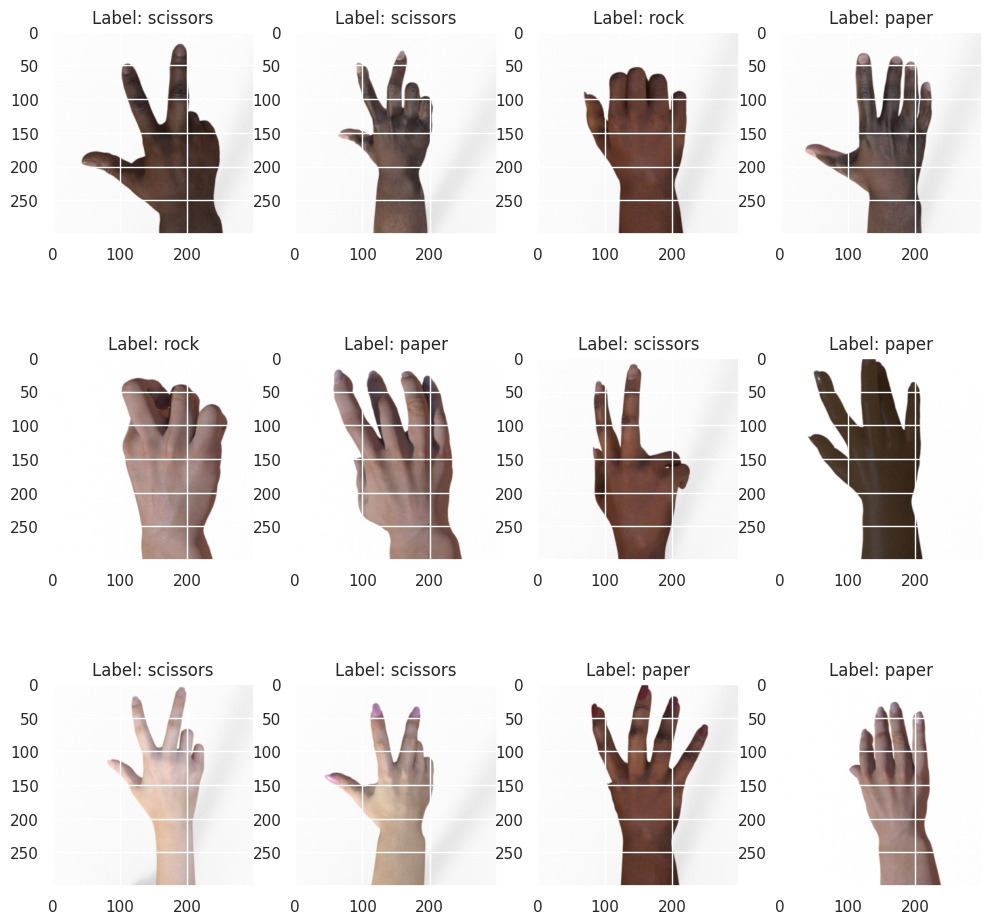

In [ ]:
from dataprocessing import preview_dataset
# Explore raw training dataset images.
preview_dataset(dataset_train_raw, get_label_name)

Now I will pre-process the images in the dataset and create train and test sets.

In [ ]:
from dataprocessing import format_example
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [ ]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [ ]:
BATCH_SIZE = 32

dataset_train_shuffled = dataset_train.shuffle(
    buffer_size=NUM_TRAIN_EXAMPLES
)

dataset_train_shuffled = dataset_train.batch(
    batch_size=BATCH_SIZE
)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
dataset_train_shuffled = dataset_train_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [ ]:
print(dataset_train_shuffled)
print(dataset_test_shuffled)

## Training the Network

Now, I will import ResNet50 directly from the ResNet50.py file and proceed to train the network. The implementation of this network closely resembles the one I previously made above. However, in this instance, I did some adjustments such as subclassing `tf.keras.models.Model` during the implementation process.

In [ ]:
from ResNet50 import ResNet50

In [ ]:
model = ResNet50(num_classes=3)

model.build(input_shape=(None, 150, 150, 3))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.009)

In [ ]:
model.summary()

Model: "res_net50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_36 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  multiple                 0         
 ng2D)                                                           
                                                         

In [ ]:
model.compile(optimizer=optimizer, loss=tf.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

history=model.fit(dataset_train_shuffled, epochs=50, validation_data=dataset_test_shuffled)

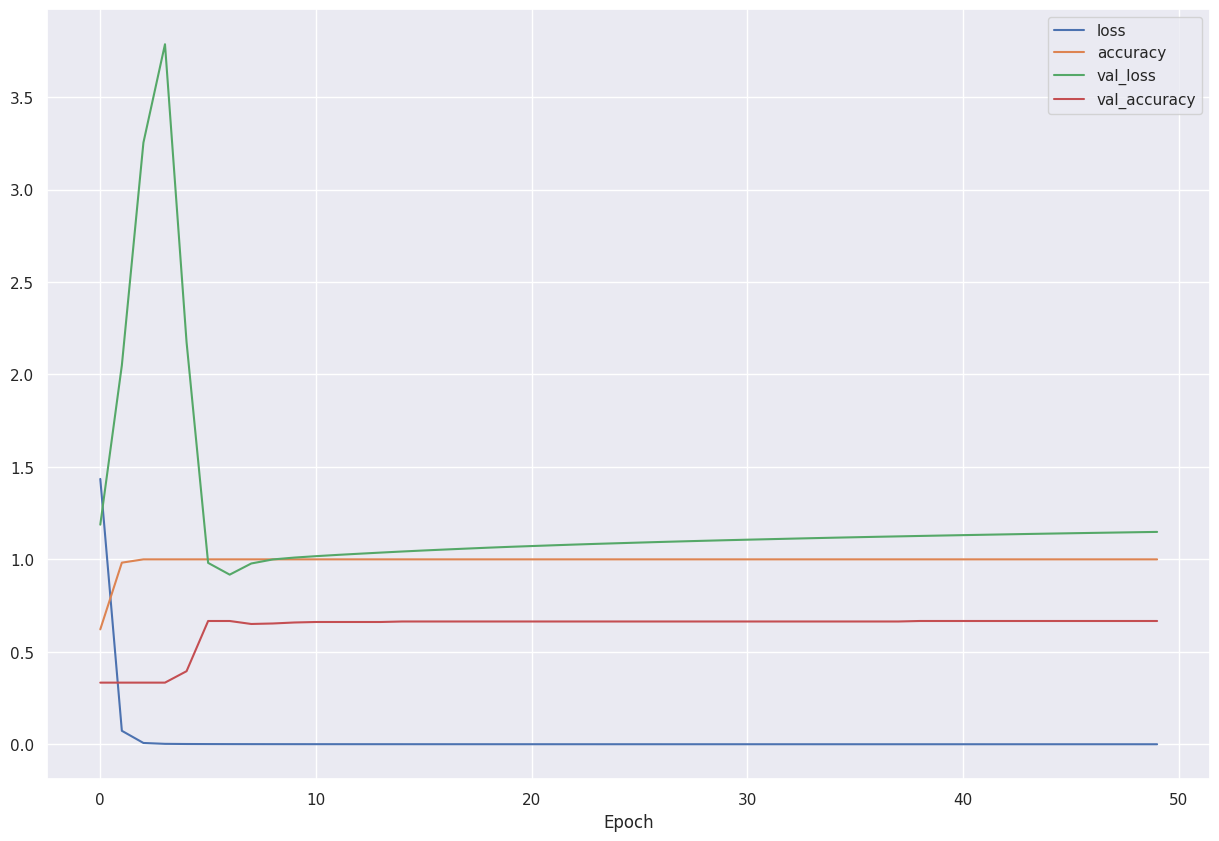

In [ ]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()

The model seems to be overfitting on the dataset. Let's see how it will perform on TF Flowers Dataset.

# TF Flowers Dataset

Now I will load TF Flowers Dataset and train the model on this dataset using various learning rate schedulers that we previously discussed.

In [ ]:
#https://medium.com/@nutanbhogendrasharma/tensorflow-image-classification-with-tf-flowers-dataset-e36205deb8fc : Credit for loading dataset
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [ ]:
num_classes=5

In [ ]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [ ]:
from dataprocessing import format_image

BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


Let's visualize one of the instances from the dataset.

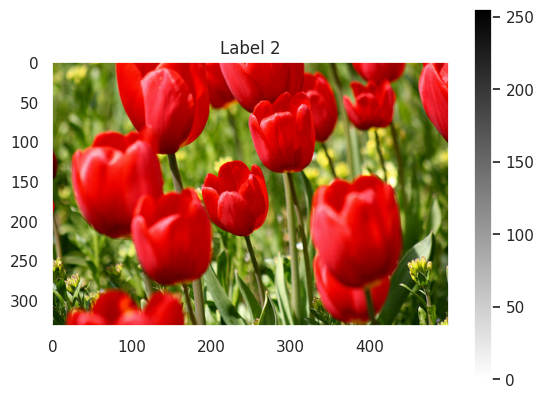

In [ ]:
for image, label in training_set.take(5):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

## Training ResNet on TF Flowers Dataset

Let's now train the model on TF Flowers Dataset.

In [ ]:
model=ResNet50(num_classes=5)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
history=model.fit(train_batches, epochs=50, validation_data=validation_batches)

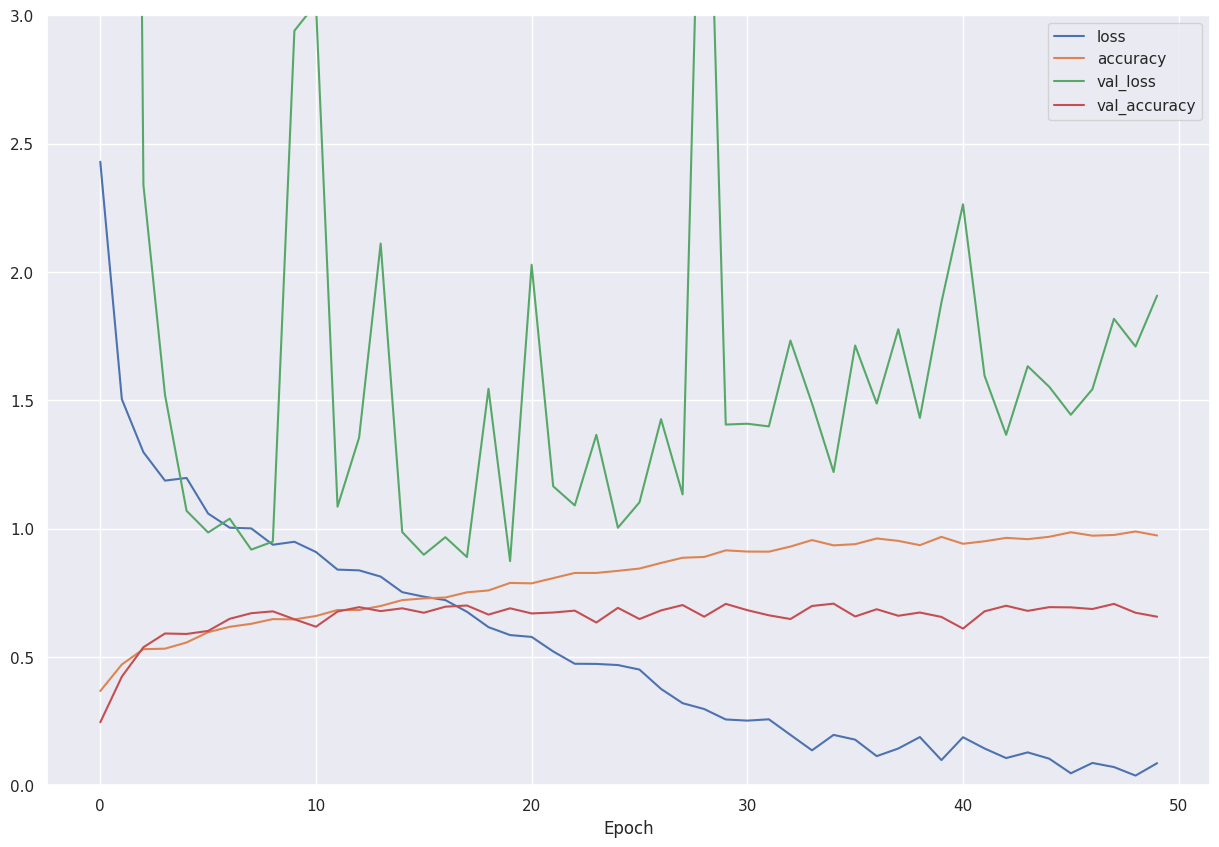

In [ ]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
# Set y-axis limits to range from 0 to 1
plt.ylim(0, 3)

plt.show()

In [ ]:
from Scheduler import WarmUpCallbackEpoch

In [ ]:
model1 = ResNet50(num_classes=5)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
lr_scheduler = WarmUpCallbackEpoch(num_epochs=50, warmup_epochs=3)
model1.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
history=model1.fit(train_batches, epochs=50, validation_data=validation_batches,callbacks=[lr_scheduler.warm_up_with_cosine_epoch()])

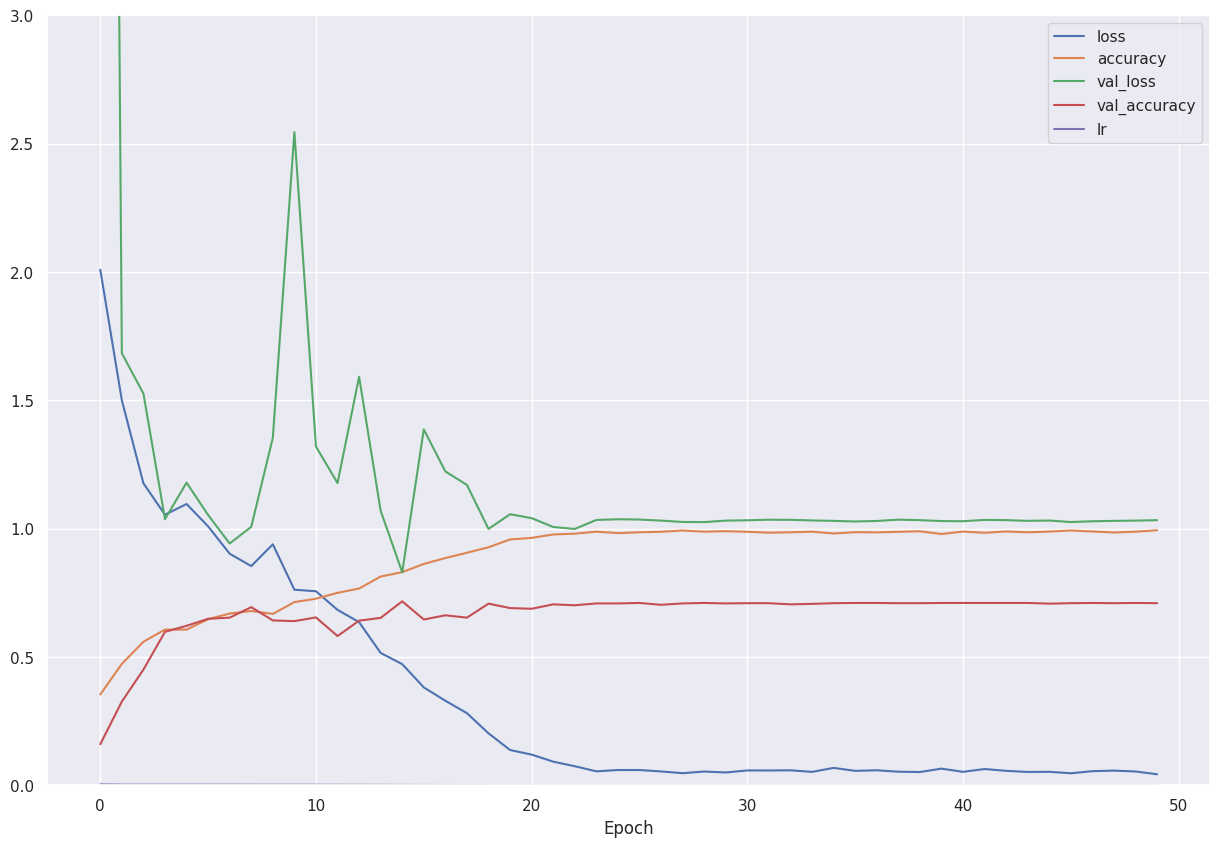

In [ ]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.ylim(0, 3)
plt.show()

In [ ]:
from Scheduler import WarmUpCallbackBatch

In [ ]:
model2 = ResNet50(num_classes=5)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
warmup_callback = WarmUpCallbackBatch(warmup_steps=250, initial_lr=0.01, num_epochs=50)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model2.fit(train_batches, epochs=50, validation_data=validation_batches,callbacks=[warmup_callback], use_multiprocessing = True, workers=4)

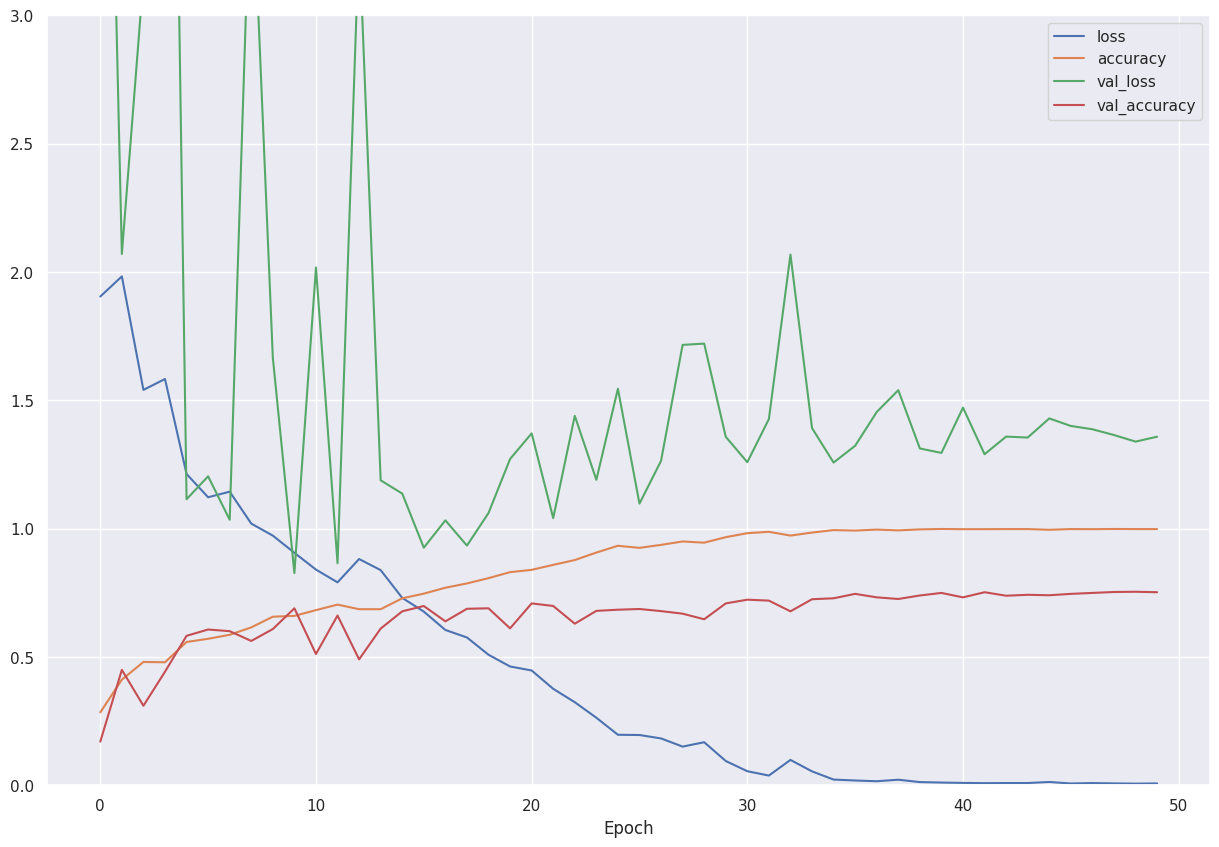

In [ ]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")

plt.ylim(0, 3)
plt.show()

In [ ]:
from Scheduler import WarmUpCosineDecayRestarts

In [ ]:
model3=ResNet50(num_classes=5)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9)
warmup_callback = WarmUpCosineDecayRestarts(num_epochs=50,warmup_steps=40, cycle_length=250)
model3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model3.fit(train_batches, epochs=50, validation_data=validation_batches,callbacks=[warmup_callback], use_multiprocessing = True, workers=4)

Epoch 1/50
 6/81 [=>............................] - ETA: 26s - loss: 1.8402 - accuracy: 0.2760

81/81 [==============================] - 55s 422ms/step - loss: 7.0917 - accuracy: 0.2674 - val_loss: 629469937664.0000 - val_accuracy: 0.1653
Epoch 2/50
81/81 [==============================] - 33s 411ms/step - loss: 2.0259 - accuracy: 0.2316 - val_loss: 54813.6758 - val_accuracy: 0.1798
Epoch 3/50
81/81 [==============================] - 33s 409ms/step - loss: 1.6441 - accuracy: 0.2647 - val_loss: 41.9654 - val_accuracy: 0.2616
Epoch 4/50
81/81 [==============================] - 33s 406ms/step - loss: 1.6400 - accuracy: 0.2631 - val_loss: 8.9157 - val_accuracy: 0.2743
Epoch 5/50
81/81 [==============================] - 33s 411ms/step - loss: 1.7018 - accuracy: 0.2581 - val_loss: 2.8562 - val_accuracy: 0.3043
Epoch 6/50
81/81 [==============================] - 33s 408ms/step - loss: 1.6530 - accuracy: 0.2666 - val_loss: 1.8198 - val_accuracy: 0.2825
Epoch 7/50
81/81 [==============================] - 33s 409ms/step - loss: 1.5974 - accuracy: 0.2705 - val_loss: 1.7842 - val_accuracy: 0

In [ ]:
sns.set_theme()
pd.DataFrame(history.history).plot(figsize=(15, 10))
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.ylim(0, 3)
plt.show()

Similar to the Inception Net, ResNet also appears to suffer from overfitting on the data, indicating a need for additional parameter tuning or architectural simplification to enhance the results. Despite the performance of ResNet on these specific toy datasets, it is crucial to understand that ResNet is a highly significant architecture family and often serves as a backbone for advanced models. Consequently, rather than solely focusing on the performance of these networks on these toy datasets and making direct comparisons, it is more important to comprehend the structure of architecture. With appropriate tuning, all the introduced models have the potential to perform admirably on these datasets.

## Additional Sources

1. [Understanding and visualizing ResNets](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8)
2. [8.6. Residual Networks (ResNet) and ResNeXt](https://d2l.ai/chapter_convolutional-modern/resnet.html)
3. [Detailed Guide to Understand and Implement ResNets](https://cv-tricks.com/keras/understand-implement-resnets/)
4. [ResNet50](https://blog.devgenius.io/resnet50-6b42934db431)
5. [How to code your ResNet from scratch in Tensorflow? ](https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/)
6. [ResNets — Residual Blocks & Deep Residual Learning](https://towardsdatascience.com/resnets-residual-blocks-deep-residual-learning-a231a0ee73d2)
7. [Intuition behind Residual Neural Networks](https://towardsdatascience.com/intuition-behind-residual-neural-networks-fa5d2996b2c7)
8. [Residual blocks — Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)
9. [Should deep residual networks be viewed as an ensemble of networks?](https://ai.stackexchange.com/questions/1997/should-deep-residual-networks-be-viewed-as-an-ensemble-of-networks?rq=1)
10. [Residual Networks (ResNet) – Deep Learning](https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/)
11. [Residual Blocks - why do they work?](https://ai.stackexchange.com/questions/30375/residual-blocks-why-do-they-work)
12. [How to build ResNet-50 from scratch?](https://www.linkedin.com/pulse/resnet50-implementation-keras-beginners-ayoub-kirouane/)
13. [Forward Stability of ResNet and Its Variants](https://link.springer.com/article/10.1007/s10851-019-00922-y)

## General References

The references below are the main sources I used for preparing the notebooks in this repository.

1. Murphy, K. P. (2022). Probabilistic machine learning: an introduction. MIT press.
2. Géron, A. (2022). Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow. " O'Reilly Media, Inc.".
3. Chollet, F. (2021). Deep learning with Python. Simon and Schuster.
4. Kar, K. (2020). Mastering Computer Vision with TensorFlow 2. x: Build advanced computer vision applications using machine learning and deep learning techniques. Packt Publishing Ltd.
5. Planche, B., & Andres, E. (2019). Hands-On Computer Vision with TensorFlow 2: Leverage deep learning to create powerful image processing apps with TensorFlow 2.0 and Keras. Packt Publishing Ltd.
6. Lakshmanan, V., Görner, M., & Gillard, R. (2021). Practical Machine Learning for Computer Vision. " O'Reilly Media, Inc.".